# Line identification

In this tutorial, we will learn how to use `spectuner` to perform line identification.

In [1]:
from pathlib import Path

import numpy as np
import spectuner

As an example, we will use the observed spectrum from a line survey towards Orion-KL at 67.0 - 93.6 GHz using GBT (Frayer et al. 2015). The data can be downloaded from VizieR at this [link](https://cdsarc.cds.unistra.fr/viz-bin/cat/J/AJ/149/162#/article). The observed spectrum is given by `table2.dat` in the downloaded data. Set `fname_spec` below to the path of `table2.dat`.

Secondly, we also require the CDMS spectroscopic database to run the code. Set ``fname_db`` below to path of the database file.

In [2]:
fname_spec = "path/to/table2.dat"
fname_db = "path/to/the/cdms/database"

### Preprocessing

Before processing an observed spectrum with Spectuner, it is important to ensure that the data meets the following requirements:

1. The spectrum must be provided as a 2D array, where the first column represents the frequency in MHz and the second column represents the intensity in K.
2. The frequency values must be in strictly increasing order.
3. The baseline of the spectrum **must** be flat and zero.
4. It is highly recommended to correct the LSR velocity of the observed spectrum to avoid any confusion when settting the bound of the offset velocity.

In [3]:
spec = np.loadtxt(fname_spec)
# Convert GHz to MHz
spec[:, 0] *= 1e3

# There is an issue in the data that the frequency is not strictly increasing
# We use the following trick to ensure that the frequency is strictly increasing
inds = np.append(0, np.where(np.diff(spec[:, 0]) > 0)[0] + 1)
spec = spec[inds]

# For speed reason, we only use a small window of the spectrum
lower = 89400
upper = 91400
spec = spec[(spec[:, 0] >= lower) & (spec[:, 0] < upper)]

### Configuration

This tutorial demonstrates the basic configuration settings required to get started with Spectuner. For more advanced options, please refer to the [user guide](../config.rst).

1. Set the path to the spectroscopic database
2. Provide beam information and RMS noise for each spectral window
    - For single dish telescopes, set ``beam_info`` to the telescope diameter in meters.
    - For interferometers, set ``beam_info`` to a tuple ``(BMAJ, BMIN)``, where ``BMAJ`` and ``BMIN`` are the major and minor axis of the synthesis beam in degrees.
3. Adjust the ``noise_factor`` to control peak detection sensitivity. The ``noise_factor`` is used to calculate the prominence threshold (``prominence=noise*noise_factor``), which determines how sensitive the peak detection is. The code uses ``find_peaks`` in Scipy to find the peaks. See this [link](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html) for more details.

In [4]:
config = spectuner.load_default_config()

# Set the path to the spectroscopic database
config.set_fname_db(fname_db=fname_db)

# Set spectral windows.
config.append_spectral_window(
    spec=spec,
    beam_info=100., # Meter
    noise=30e-3, # K
)
config.set_peak_manager(
    noise_factor=4.
)

We can plot the observed spectrum and the identified peaks to check if the settings are expected. The blue vertical lines in the plot show peaks identified by the peak finder.

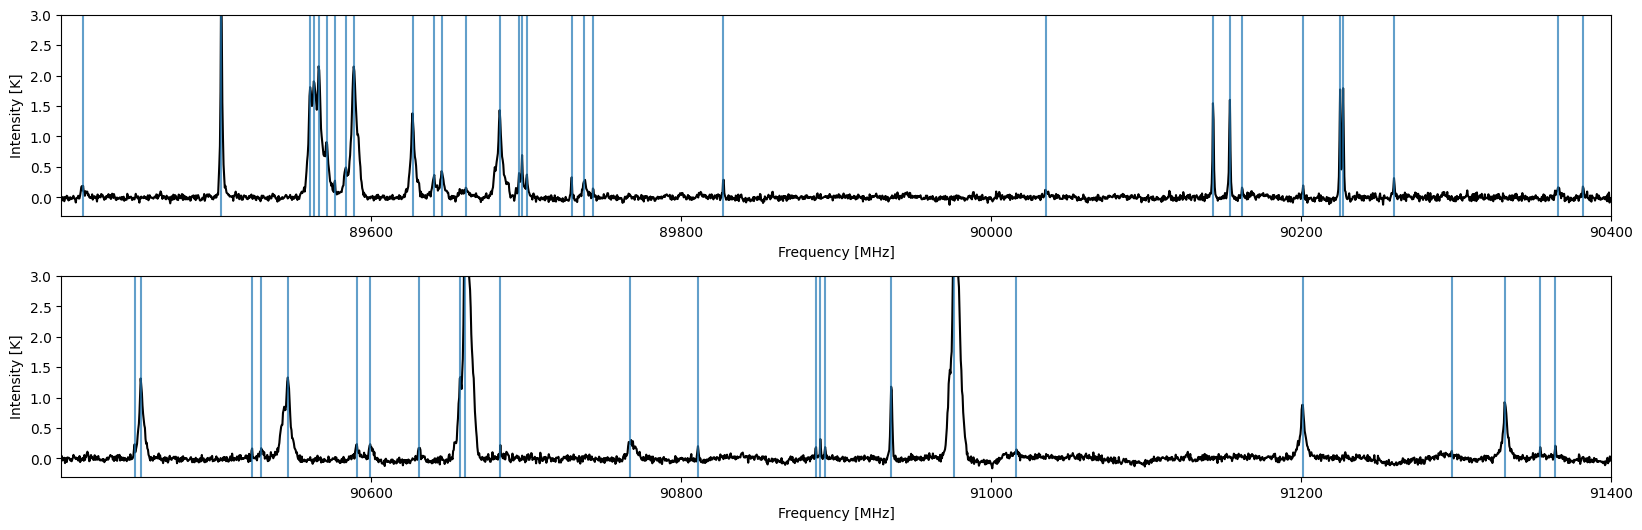

In [5]:
peak_manager = spectuner.PeakManager.from_config(config)
plot = spectuner.SpectralPlot.from_config(config)
plot.vlines(peak_manager.freqs_peak, alpha=0.7)

Next, we can configure the chemical species for the identification. In this example, we will specify C2H5CN and HCCCN as the target molecules. The code will automatically include their possible vibrational states and isotopologues. Set ``species=None`` to search all possible species.

In [6]:
config.set_ident_species(speices=["C2H5CN", "HCCCN"])

Here are some settings related to the spectral line fitting.

1. Use Particle Swarm Optimization for line identification, i.e. ``method="pso"``.  This is a global optimization method with stochastic properties, meaning that running the algorithm multiple times may yield better results. Start from ``n_trial=1`` and increase ``n_trial`` to achieve more stable and consistent fits.
2. Set appropriate bounds for fitting parameters. When defining the parameter bounds, be mindful of if the parameter is in log-scale. To fix a parameter, a trick is to set the lower bound very close to (but not exactly equal to) its upper bound .
3. A portion of the code is parallelized using Python’s multiprocessing module.
Set ``n_process`` to specify how many CPU cores to use.

In [7]:
# Set optimizer
config.set_optimizer(method="pso", n_trial=1)

# Set source size bound to 10^0.7=5 to 10^2.3=200 arcsec
config.set_param_info("theta", is_log=True, bound=(0.7, 2.3))
# Set temperature bound to 10 to 400 K
config.set_param_info("T_ex", is_log=False, bound=(10, 400))
# Set column density bound to 10^12 to 10^20 cm^-2
config.set_param_info("N_tot", is_log=True, bound=(12, 20))
# Set velocity width bound to 1 to 25 km/s
config.set_param_info("delta_v", is_log=False, bound=(1, 25))
# Set velcocity offset bound to -12 to 12 km/s
config.set_param_info("v_offset", is_log=False, bound=(-12, 12))

# Set the number of processes
config.set_n_process(n_process=3)

Finally, as a good practice, we save the config to the same directory where the identification results will be stored. This helps keep the project organized and ensures that all relevant settings are preserved for future reference or reproducibility.

In [8]:
# Set the directory to save results
result_dir = Path("results/")
result_dir.mkdir(exist_ok=True)

# Save the configuration
spectuner.save_config(config, result_dir/"config.pickle")

print(config)

{'obs_info': [{'spec': array([[ 8.9400202e+04,  1.0575000e-02],
       [ 8.9400592e+04, -1.5704000e-02],
       [ 8.9400983e+04, -4.9503000e-02],
       ...,
       [ 9.1398901e+04, -4.8600000e-02],
       [ 9.1399292e+04,  3.3773000e-02],
       [ 9.1399682e+04, -3.0269000e-02]]),
               'beam_info': 100.0,
               'T_bg': 0.0,
               'need_cmb': True,
               'noise': 0.03}],
 'fname_base': None,
 'sl_model': {'fname_db': '/home/yqiu/projects/spectuner-tutorial/cdms_lite.db'},
 'param_info': {'theta': {'is_shared': False,
                          'is_log': True,
                          'bound': (0.7, 2.3)},
                'T_ex': {'is_shared': False,
                         'is_log': False,
                         'bound': (10, 400)},
                'N_tot': {'is_shared': False,
                          'is_log': True,
                          'bound': (12, 20)},
                'delta_v': {'is_shared': False,
                            'is_log

### Running the algorithm

Now, we can run the line idetentification algorithm, which has two phases:

1. ``run_individual_line_id``: The algorithm performs one-by-one fittings for each molecule in the user-defined list.
2. ``run_combining_line_id``: The algorithm combines the individual fitting results using a greedy method. It sorts the fitting results by their loss values, starting with the best fit, and sequentially merges them.

Please refer to Qiu et al. (2025) for a detailed description of the algorithm.

In [9]:
%%time

spectuner.run_individual_line_id(config, result_dir)
spectuner.run_combining_line_id(config, result_dir)

100%|███████████████████████████████████████████████████████████████| 21/21 [00:06<00:00,  3.24it/s]
Fitting: 0it [00:00, ?it/s]


CPU times: user 17.3 s, sys: 48 s, total: 1min 5s
Wall time: 3min 17s


### Checking the results

We may use the ``ResultManager`` to check the results. For each phase, fitting results store the output of the optimization algorithm and identification results store the the scores related to the identification. ``ResultManager`` provides ``load_fitting_result`` and ``load_ident_result`` to load the results. If no peaks are found in the best-fitting model spectrum, the result will only exist in the fitting results but not in the identification results.

In [10]:
result_mgr = spectuner.ResultManager(result_dir)
result_mgr

Fitting results (single):
  - 0_C-13-H3C-13-H2CN;v=0;
  - 10_HCC-13-C-13-N;v=0;
  - 11_HCC-13-CN;v5=1;
  - 12_HCC-13-CN;v6=1;
  - 13_HCC-13-CN;v7=1;
  - 14_HCC-13-CN;v7=3;
  - 15_HCC-13-CN;v=0;
  - 16_HCCC-13-N;v5=1;
  - 17_HCCC-13-N;v=0;
  - 18_HCCCN;v2=1;
  - 19_HCCCN;v6=1;
  - 1_C-13-H3CH2C-13-N;v=0;
  - 20_HCCCN;v7=1;
  - 21_HCCCN;v=0;
  - 2_C-13-H3CH2CN;v=0;
  - 3_C2H5CN;v12=1;
  - 4_C2H5CN;v20=1;
  - 5_C2H5CN;v=0;
  - 6_CH3C-13-H2C-13-N;v=0;
  - 7_CH3C-13-H2CN;v=0;
  - 8_CH3CHDCN;v=0;
  - 9_HC3N;v5=1,v7=1;

Identification results (single):
  - 0_C-13-H3C-13-H2CN;v=0;
  - 10_HCC-13-C-13-N;v=0;
  - 11_HCC-13-CN;v5=1;
  - 12_HCC-13-CN;v6=1;
  - 13_HCC-13-CN;v7=1;
  - 14_HCC-13-CN;v7=3;
  - 15_HCC-13-CN;v=0;
  - 17_HCCC-13-N;v=0;
  - 18_HCCCN;v2=1;
  - 19_HCCCN;v6=1;
  - 20_HCCCN;v7=1;
  - 21_HCCCN;v=0;
  - 4_C2H5CN;v20=1;
  - 5_C2H5CN;v=0;
  - 6_CH3C-13-H2C-13-N;v=0;
  - 8_CH3CHDCN;v=0;
  - 9_HC3N;v5=1,v7=1;

Fitting results (combine):
  - 0_C-13-H3C-13-H2CN;v=0;
  - 10_HCC-13-C-13-

We are most interested in the final result of the combining phase, which summarizes the molecules that have been identified with more than three matching spectral peaks.

The result  can be loaded using code below. We may use ``ResultManager.derive_df_mol`` to check the parameters and scores for each molecule, which returns a Pandas DataFrame. Here is the meaning of the columns:

- 'theta': Source size in arcsec.
- 'T_ex': Excitation temperature in K.
- 'N_tot': Total column density in cm^-2.
- 'delta_v': Line width in km/s.
- 'v_offset': velocity offset in km/s.
- 'loss': Total peak matching fitness. This is roughly equal to the sum of the intesity of all peaks.
- 'score': Total peak matching score. This is roughly equal to the sum of the noramlized score of all peaks.
- 'num_tp': Number of matched peaks.
- 'num_tp_i': Number of matched peaks which have contributions from only one molecule.
- 'num_fp': Number of peaks found in the model spectrum but missed in the observed spectrum.
- 'tx_score': The x-th largest value among all socres of matched peaks.


In [11]:
res = result_mgr.load_ident_result("combine", "combine")
res.derive_df_mol()

,id,name,master_name,theta,T_ex,N_tot,delta_v,v_offset,loss,score,num_tp,num_tp_i,num_fp,t1_score,t2_score,t3_score
0,5,C2H5CN;v=0;,C2H5CN;v=0;,47.774352,397.038391,1.011502e+16,7.815331,5.477122,-10.056403,7.207908,12,12,0,0.952545,0.932772,0.896882


We may use code below to plot the combined result.

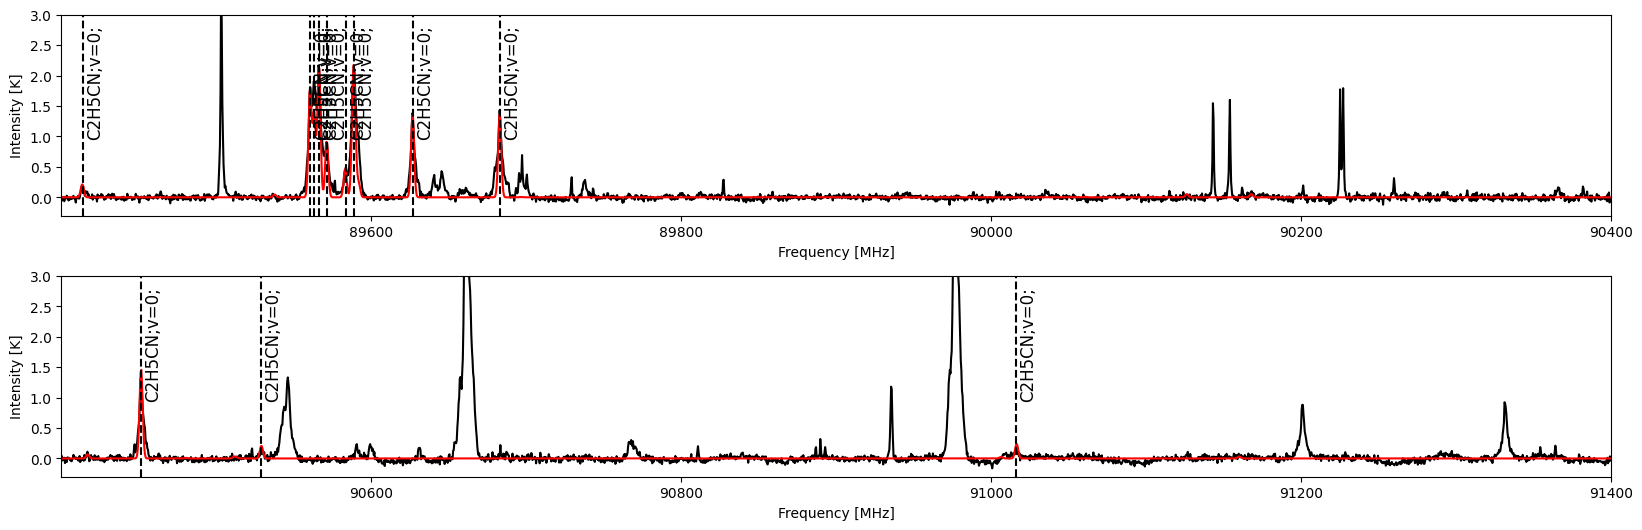

In [12]:
plot = spectuner.SpectralPlot.from_config(config)
plot.plot_ident_result(res, kwargs_spec={"color": "r"})

The combined result excludes molecules which have one or two matched peaks. Use the code below to show a summary of such molecules.

In [13]:
df_cand = result_mgr.derive_df_mol_master()
df_cand

,id,master_name,loss,score,num_tp,num_tp_i,num_fp,t1_score,t2_score,t3_score
0,20,HCCCN;v7=1;,-1.576814,1.906505,2,2,0,0.988138,0.918366,0.0
1,4,C2H5CN;v20=1;,-0.295750,-0.677554,2,2,5,0.759093,0.613744,0.0
2,0,C-13-H3C-13-H2CN;v=0;,-0.139516,0.999980,1,1,1,0.999980,0.000000,0.0
3,13,HCC-13-CN;v7=1;,-0.775762,0.124997,1,1,1,0.999967,0.000000,0.0
4,10,HCC-13-C-13-N;v=0;,-0.146280,0.999950,1,1,0,0.999950,0.000000,0.0
5,14,HCC-13-CN;v7=3;,-0.093758,0.999347,1,1,0,0.999347,0.000000,0.0
6,12,HCC-13-CN;v6=1;,-0.132314,0.812878,1,1,1,0.997618,0.000000,0.0
7,21,HCCCN;v=0;,-7.212780,0.996952,1,1,0,0.996952,0.000000,0.0
8,19,HCCCN;v6=1;,-0.267386,0.136174,1,1,1,0.987484,0.000000,0.0
9,8,CH3CHDCN;v=0;,-0.234165,0.986852,1,1,0,0.986852,0.000000,0.0


We can access and visualize the identitfication result of HCCCN, v7=1 (``id=20``) using the following code.

In [14]:
res_cand = result_mgr.load_ident_result("combine", "20_HCCCN;v7=1;")
res_cand.derive_df_mol()

,id,name,master_name,theta,T_ex,N_tot,delta_v,v_offset,loss,score,num_tp,num_tp_i,num_fp,t1_score,t2_score,t3_score
0,20,HCCCN;v7=1;,HCCCN;v7=1;,36.426751,182.712601,8.954093e+14,7.823532,5.327085,-1.576814,1.906505,2,2,0,0.988138,0.918366,0.0


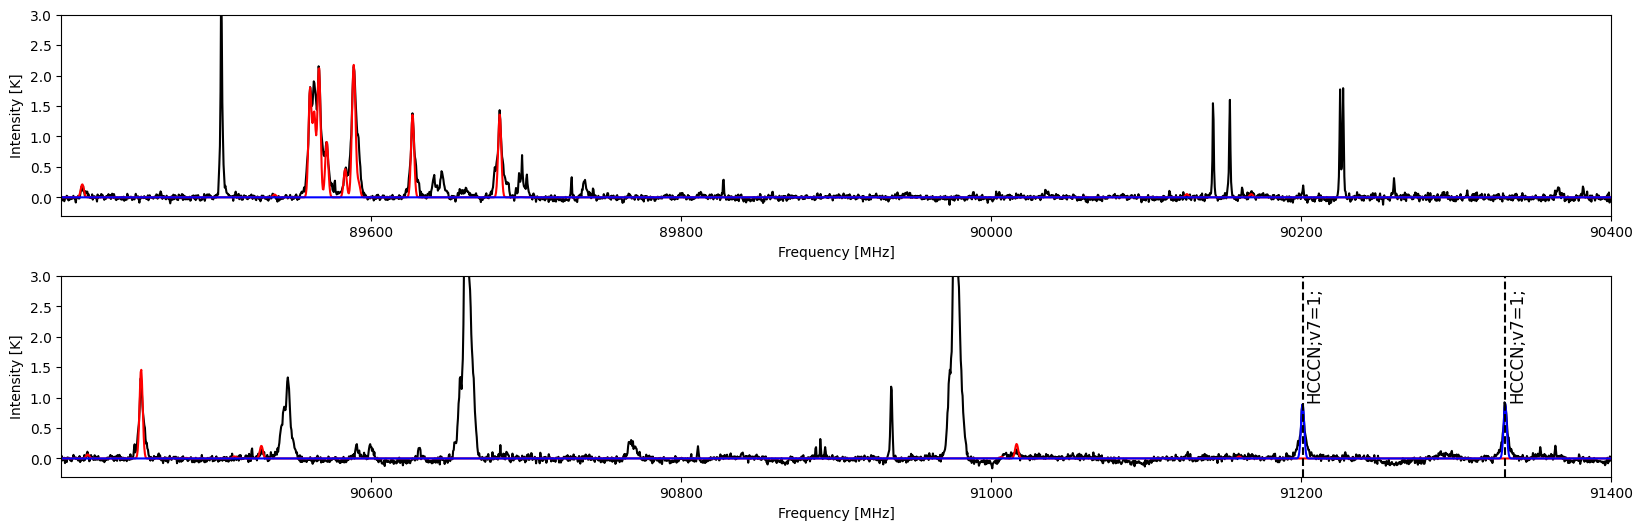

In [15]:
plot = spectuner.SpectralPlot.from_config(config)
plot.plot_ident_result(res, show_lines=False, kwargs_spec={"color": "r"})
plot.plot_ident_result(res_cand, kwargs_spec={"color": "b"})

We are able to modify the combined result. The code below adds HCCCN, v7=1 (``id=20``) to the combined result. For applications using Python scripts instead of notebooks, we may use ``load_config`` to load the configuration file saved before.

In [16]:
config = spectuner.load_config(result_dir/"config.pickle")
config.set_modificaiton_lists(include_id_list=[20])
spectuner.modify(config, result_dir)

If this has been done sucessfully, we can use the following code to access and visualize the modified result.

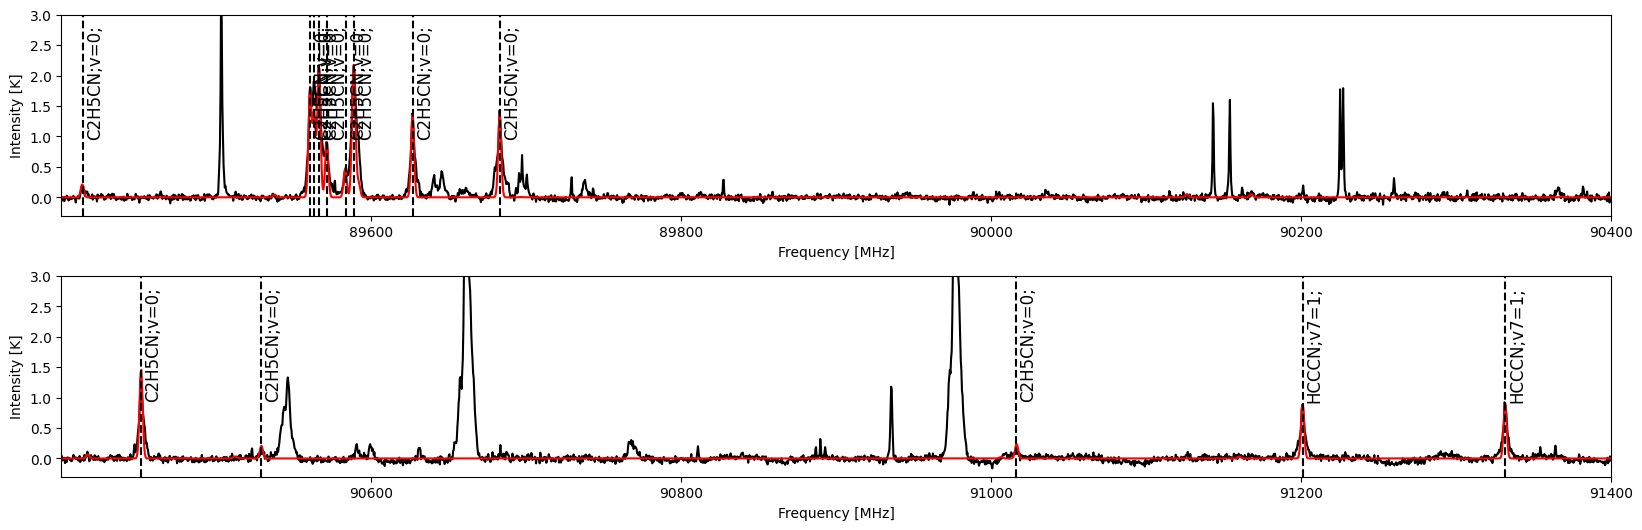

In [17]:
# To access the modified result, we need to create a new ResultManager object.
result_mgr = spectuner.ResultManager(result_dir)
res_modify = result_mgr.load_ident_result("modified", "combine")

plot = spectuner.SpectralPlot.from_config(config)
plot.plot_ident_result(res_modify, kwargs_spec={"color": "r"})

### Exercises

- For observations made with single-dish telescopes, the RMS noise is not uniform across the entire spectrum. To account for this variation, try dividing the spectrum into multiple spectral windows and assign appropriate RMS noise values to each window before performing the identification.

### References
- Frayer, D. T., Maddalena, R. J., Meijer, M., et al. (2015), The GBT 67-93.6 GHz Spectral Line Survey of Orion-KL, The Astronomical Journal, 149, 162.
- Qiu, Y., Zhang, T., Möller, T., et al. (2025), Spectuner: A Framework for Automated Line Identification of Interstellar Molecules, The Astrophysical Journal Supplement Series, 277, 21.